In [2]:
include(raw"C:\Documents\Research Professor\Mikhail Erementchouk\HN_V2\scripts\intro.jl")

using Graphs
using SimpleWeightedGraphs
using Dice 
using PrettyTables
using LinearAlgebra

using GraphPlot
using Plots
using HNProcess
using RSGraphics
using DataRefine
using PartitioningData
using Random
using LaTeXStrings

Currently active project is: HN_V2

Path of active project: C:\Documents\Research Professor\Mikhail Erementchouk\HN_V2

Have fun with your new project!

You can help us improve DrWatson by opening
issues on GitHub, submitting feature requests,
or even opening your own Pull Requests!



[ Info: Precompiling HNProcess [top-level] (cache misses: wrong source (2))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up
[ Info: Precompiling RSGraphics [top-level] (cache misses: wrong source (2))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up
[ Info: Precompiling DataRefine [top-level] (cache misses: wrong source (2))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up
[ Info: Precompiling PartitioningData [top-level] (cache misses: wrong source (2))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up


In [1]:
sim_time = 4
steps = 3000
im_all = orthogonal_image_generator(16)
im_all_vec = vec.(im_all)
println(length(im_all))
selected::Vector{Matrix{Int64}} = []
#sl::Vector{Int64}=shuffle(1:64)[1:7] #random
sl::Vector{Int64}=[3,8,10,14] #random
for t in sl
    push!(selected, im_all[t])
end
parameters = Dict{String, Any}(
    "images" => selected,
    "sim_time" => sim_time,
    "steps" => steps,
    "iterations" => 100, #Num of times attempted
    "num_agitations" => 1,
    "scaling" => 1.0,
    "delta" => -1* sim_time/steps,
    # This is the region that we will provide and the machine must keep this region constant
    # Will be a vector of tuples which are (row, col, state)
    "initial_stimuli" => [(1,1,1)]
)
println(length(parameters["images"]))
@show length(parameters["images"])
 m = filter(x -> !(x in sl), 1:64)
@show m
 f = filter(x -> x in sl, 1:64)
@show f

LoadError: UndefVarError: `orthogonal_image_generator` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

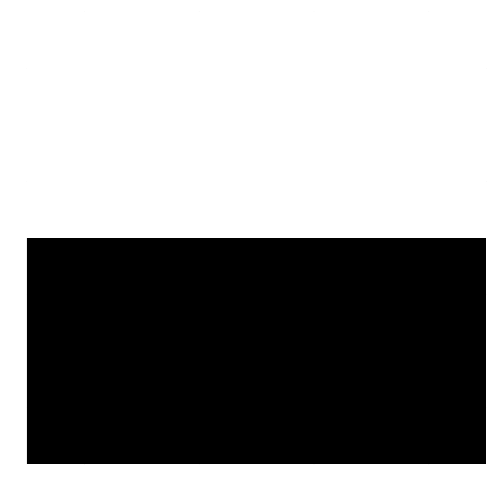

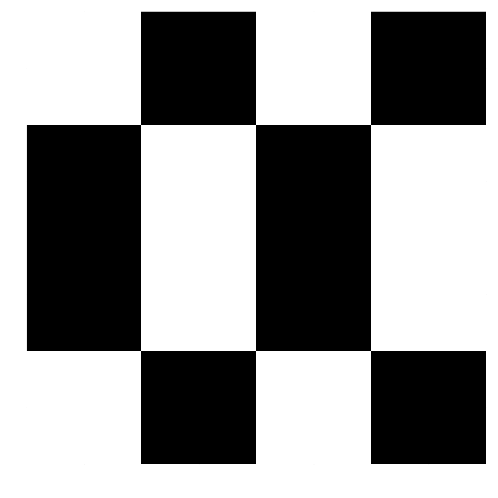

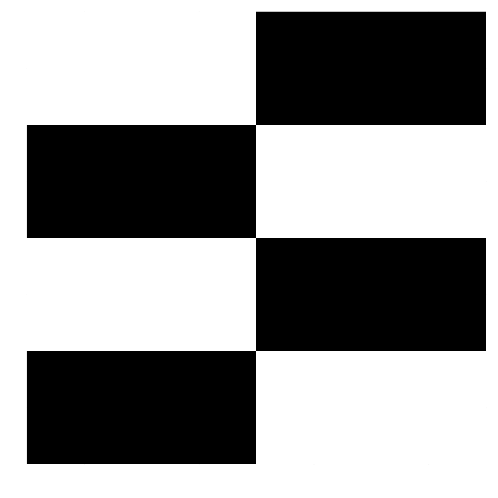

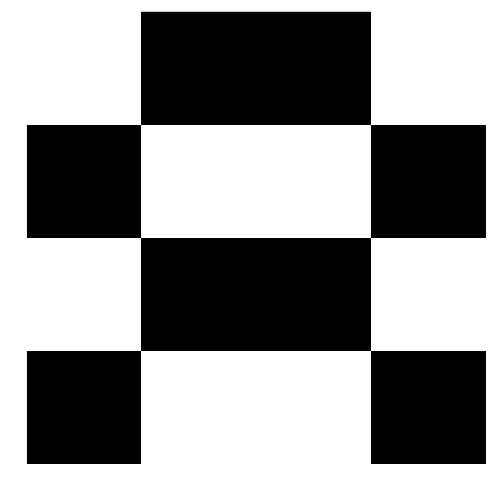

In [7]:
l=0
for i in parameters["images"]
    l+=1
    binary_image_visualizer(i,500,"image_$(l)_t1",sav= false,d= true)
end

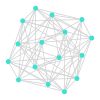

In [69]:
# Graph Checker
graph = get_HN_graph(parameters["images"],1.0)

elabels = [weights(graph)[e.src, e.dst] for e in edges(graph)]

# Plot with edge labels
 gplot(graph)

In [9]:
println(is_connected(graph))
println(maximum(weights(graph)))
println(minimum(weights(graph)))
@show sum(abs.(weights(graph)))

true
2.0
-4.0
sum(abs.(weights(graph))) = 320.0


320.0

In [18]:
i_s = Dice.get_random_hybrid(16, 2.0)

(Int8[1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, 1], [0.27632710658150894, 0.17262001096814505, -0.28546126333537636, -0.3023865777863959, 0.009122703259779152, 0.22886623445059073, -0.20564898405254306, -0.03151308597485025, 0.3168528875498464, -0.33508772376334917, -0.08702949697329498, 0.9090722963938005, -0.7578742992786811, -0.000724817351108964, 0.45765020670209133, -0.8150529700049651])

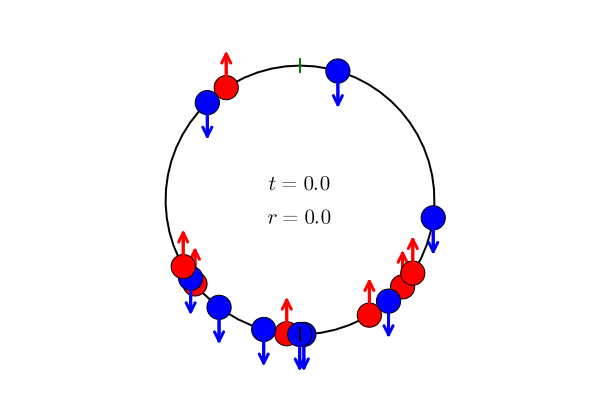

In [32]:
p0 = make_circle()
add_state(i_s[1], i_s[2])
RSGraphics.show_dash(0.0, 0.1)

# optional annotations can be added
t_label_x = 0.0
t_label_y = 0.125
t_label_str = "t = $(round(0.0, digits = 2))"
annotate!(t_label_x, t_label_y, latexstring(t_label_str))

r_label_x = 0.0
r_label_y = -0.125
r_label_str = "r = $(round(0.0, digits = 2))"
annotate!(r_label_x, r_label_y, latexstring(r_label_str))
RSGraphics.show_dash(1.0, 0.1, :green)

plot!(p0, dpi = 100)


In [35]:
function HN_Solver_Traj_test(parameters::Dict{String, Any}, initial_state::Dice.Hybrid, debug::Bool = false)
    # Just gets raw result, no visualizer

    scaling = parameters["scaling"] #Scaling coeff
    S = parameters["images"] # Images
    time_total= parameters["sim_time"] # how long the sim is
    num_steps = parameters["steps"] # number of steps in the sim
    dt_sim = parameters["delta"] # dt
    delta_t = time_total/num_steps
    traj_collection::Vector{Vector{Dice.Hybrid}} = []

    # Make Graph
    graph_set = get_HN_graph(S, scaling)
    
    # Making model
    model = Dice.Model(graph_set, Dice.model_2_hybrid_coupling, delta_t)

    # Making randomized initial state
    num_vertices = Graphs.nv(model.graph)
    
    converged = 0
    diverged = 0


    pinned::Vector{Tuple{Int64, Int8}} = []
    state::Dice.Hybrid = Dice.get_random_hybrid(num_vertices, 2.0)
    #println(reshape(state[1],size(parameters["images"][1],1),size(parameters["images"][1],1)))
    for stim in parameters["initial_stimuli"]
        # Every n entries is a column, thus taking # of columns and subtracting 1 brings you to where the column begins
        # Adding 1 will bring you to the first entry in the column and so on for +k
        pos = (stim[2]-1) * size(parameters["images"][1],1) + stim[1]
        state[1][pos] = stim[3]
        push!(pinned, (pos, stim[3]))
    end
    #println(state[1]
    traj = Dice.trajectories_pinned(model.graph, num_steps, dt_sim, model.coupling, state, pinned)
    push!(traj_collection, traj)
    # Comment out the other part of the or conditional to ignore negative images
 #=   if (reshape(state[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"] ||
        -1 .*reshape(state[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"])
        converged += 1
        global sol = state[1]
        break
    end =#

    
    if debug
        pretty_table(reshape(traj[end][1],size(parameters["images"][1],1),size(parameters["images"][1],1)))
    end
    return(state,traj_collection)
end    

HN_Solver_Traj_test (generic function with 2 methods)

In [38]:
res = HN_Solver_Traj_test(parameters, i_s);

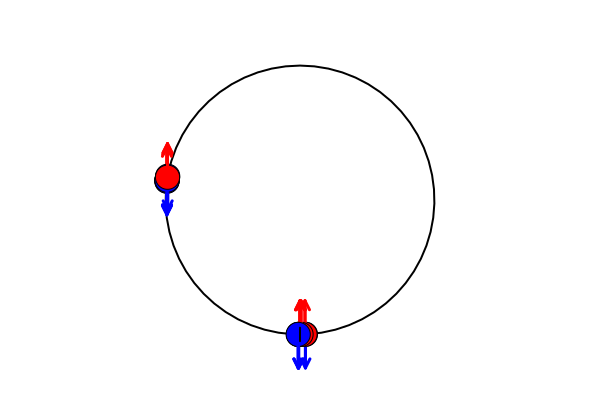

In [39]:
p1 = show_state(res[1][1], res[1][2])

In [120]:
show_dash_test(X ::Float64, dash_len ::Float64) = begin
    (x_pos, y_pos) = get_pos(X)
    Plots.plot!([x_pos, x_pos],
                [y_pos - dash_len/2, y_pos + dash_len/2],
                color = c, linewidth = 2, label = false)
end

show_dash_test (generic function with 1 method)

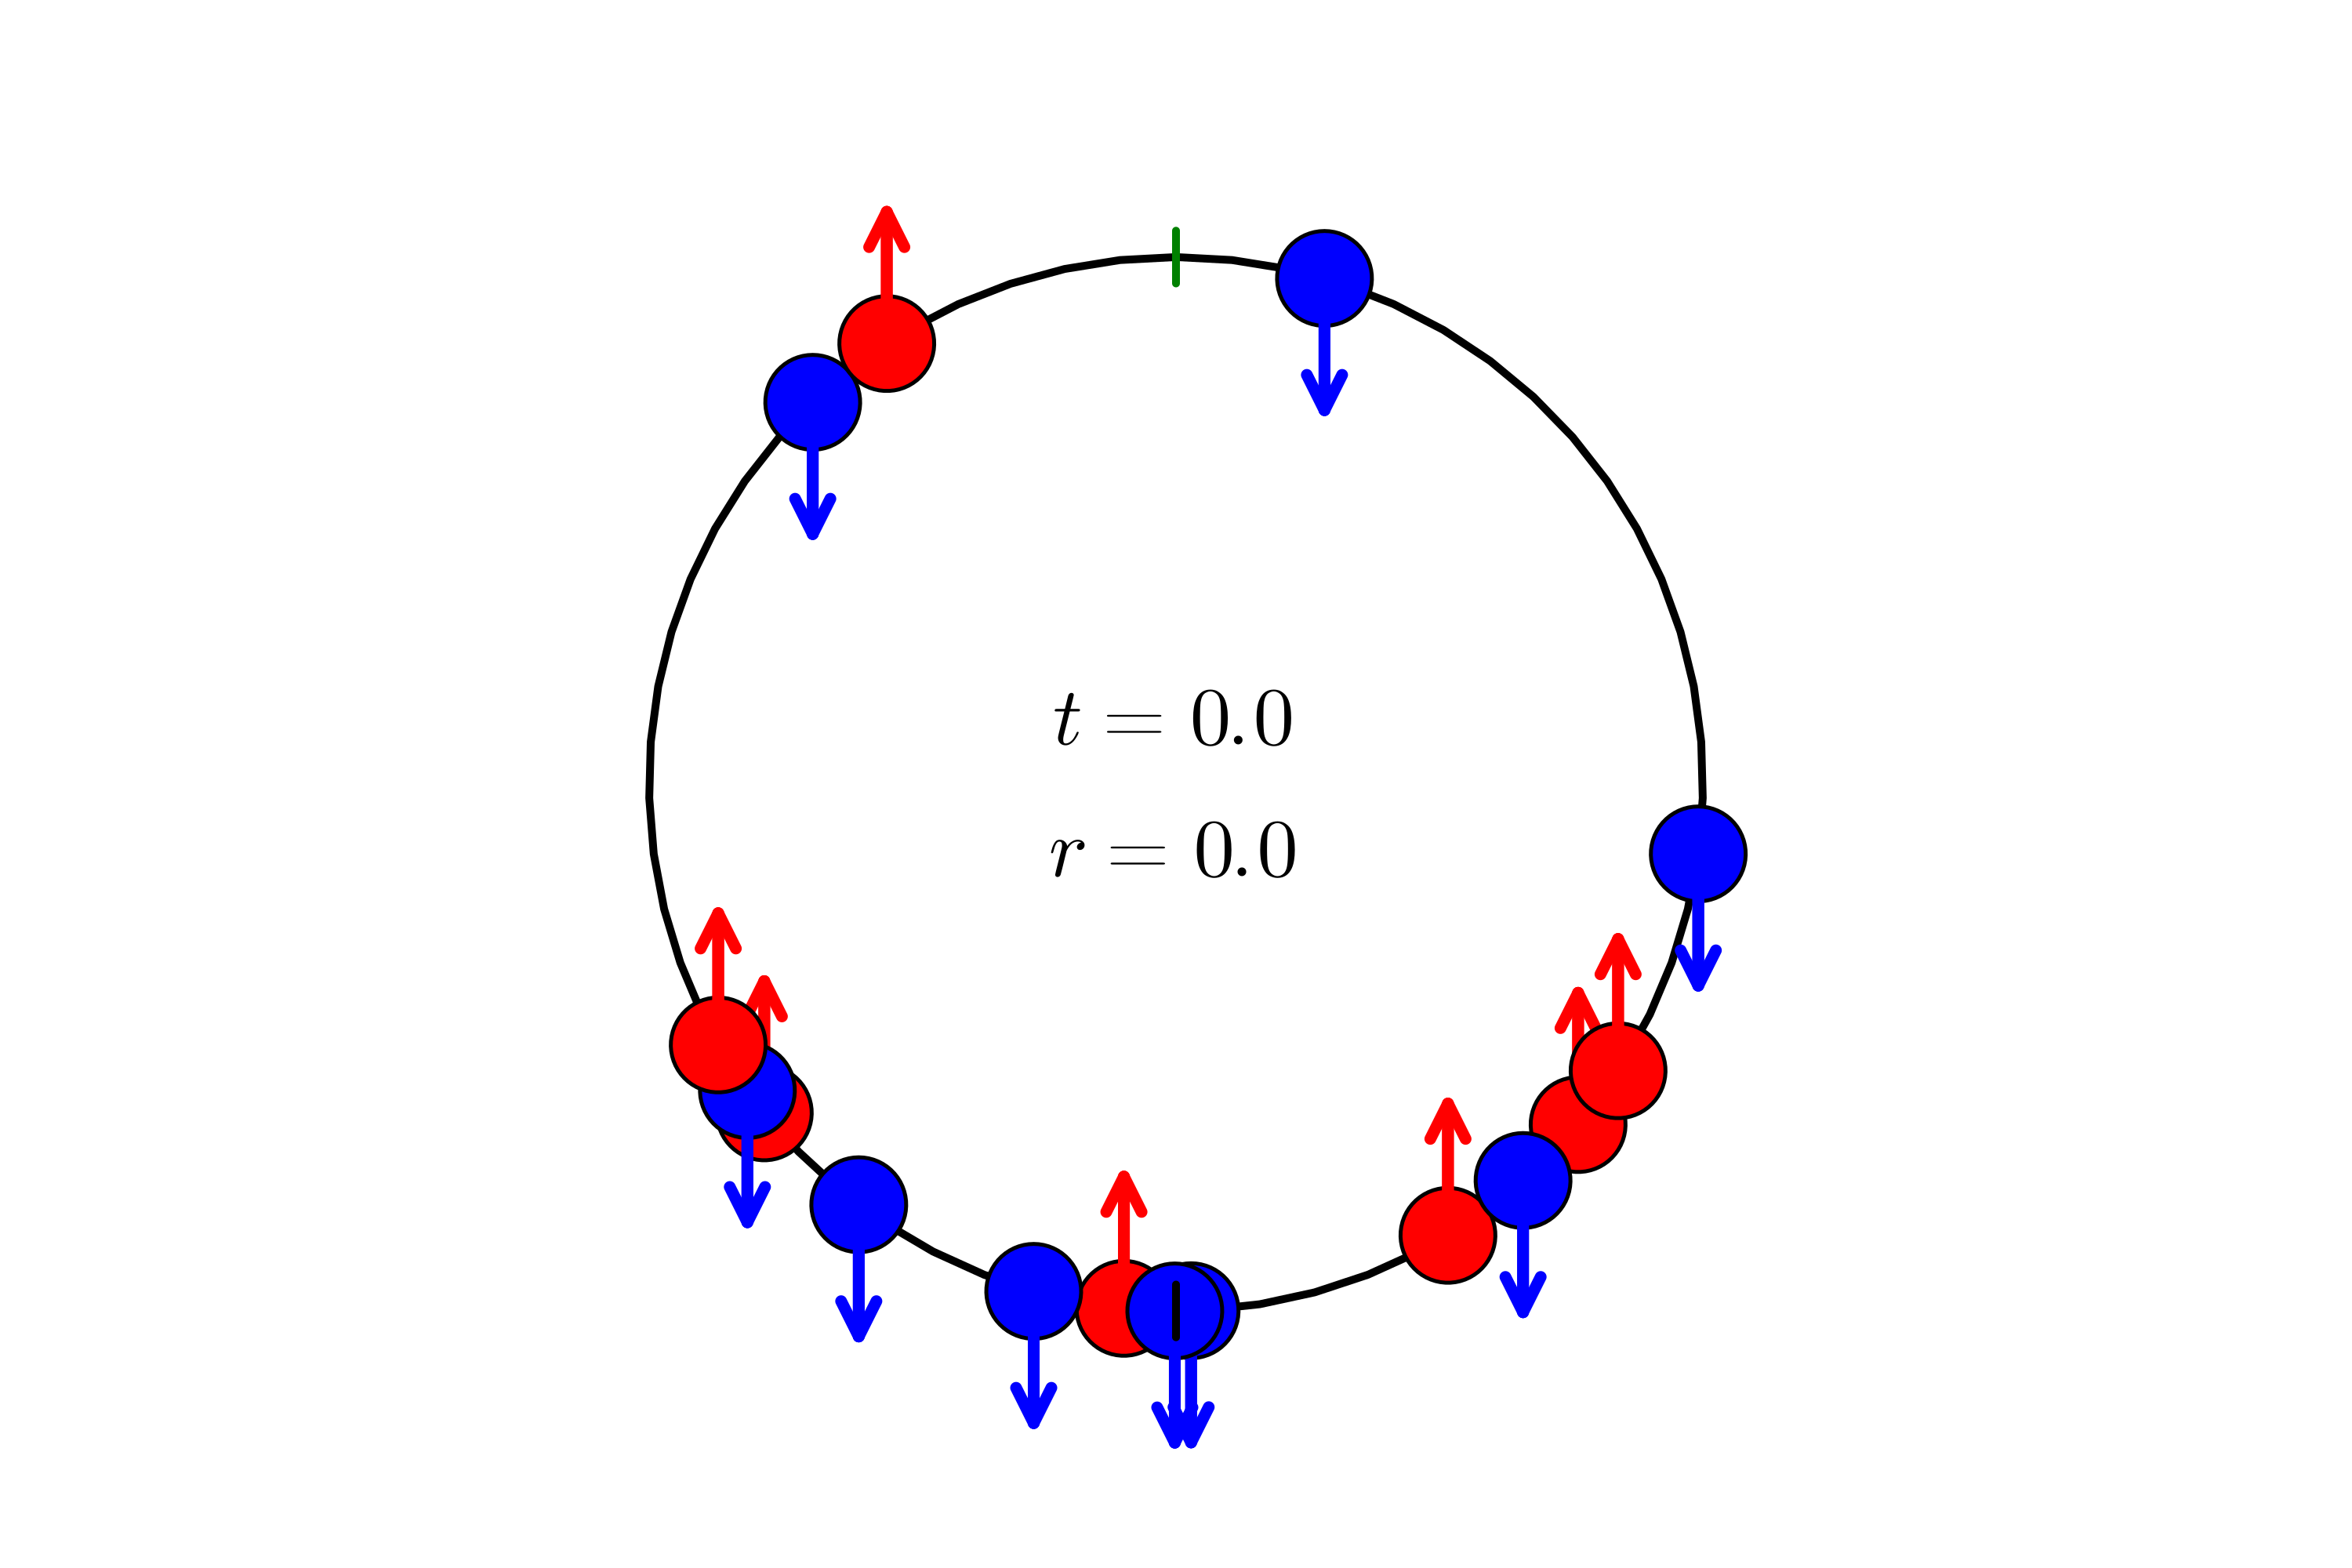

In [40]:
p0 = make_circle()
add_state(i_s[1], i_s[2])
RSGraphics.show_dash(0.0, 0.1)

# optional annotations can be added
t_label_x = 0.0
t_label_y = 0.125
t_label_str = "t = $(round(0.0, digits = 2))"
annotate!(t_label_x, t_label_y, latexstring(t_label_str))

r_label_x = 0.0
r_label_y = -0.125
r_label_str = "r = $(round(0.0, digits = 2))"
annotate!(r_label_x, r_label_y, latexstring(r_label_str))
RSGraphics.show_dash(1.0, 0.1, :green)

plot!(p0, dpi = 500)


In [41]:
savefig(p0, "Initial_State_Example_p0_meth.png")

"/Users/quaidzahid/Documents/Research Professor/Mikhail Erementchouk/HN_V2/scripts/Paper Figures/Initial_State_Example_p0_meth.png"

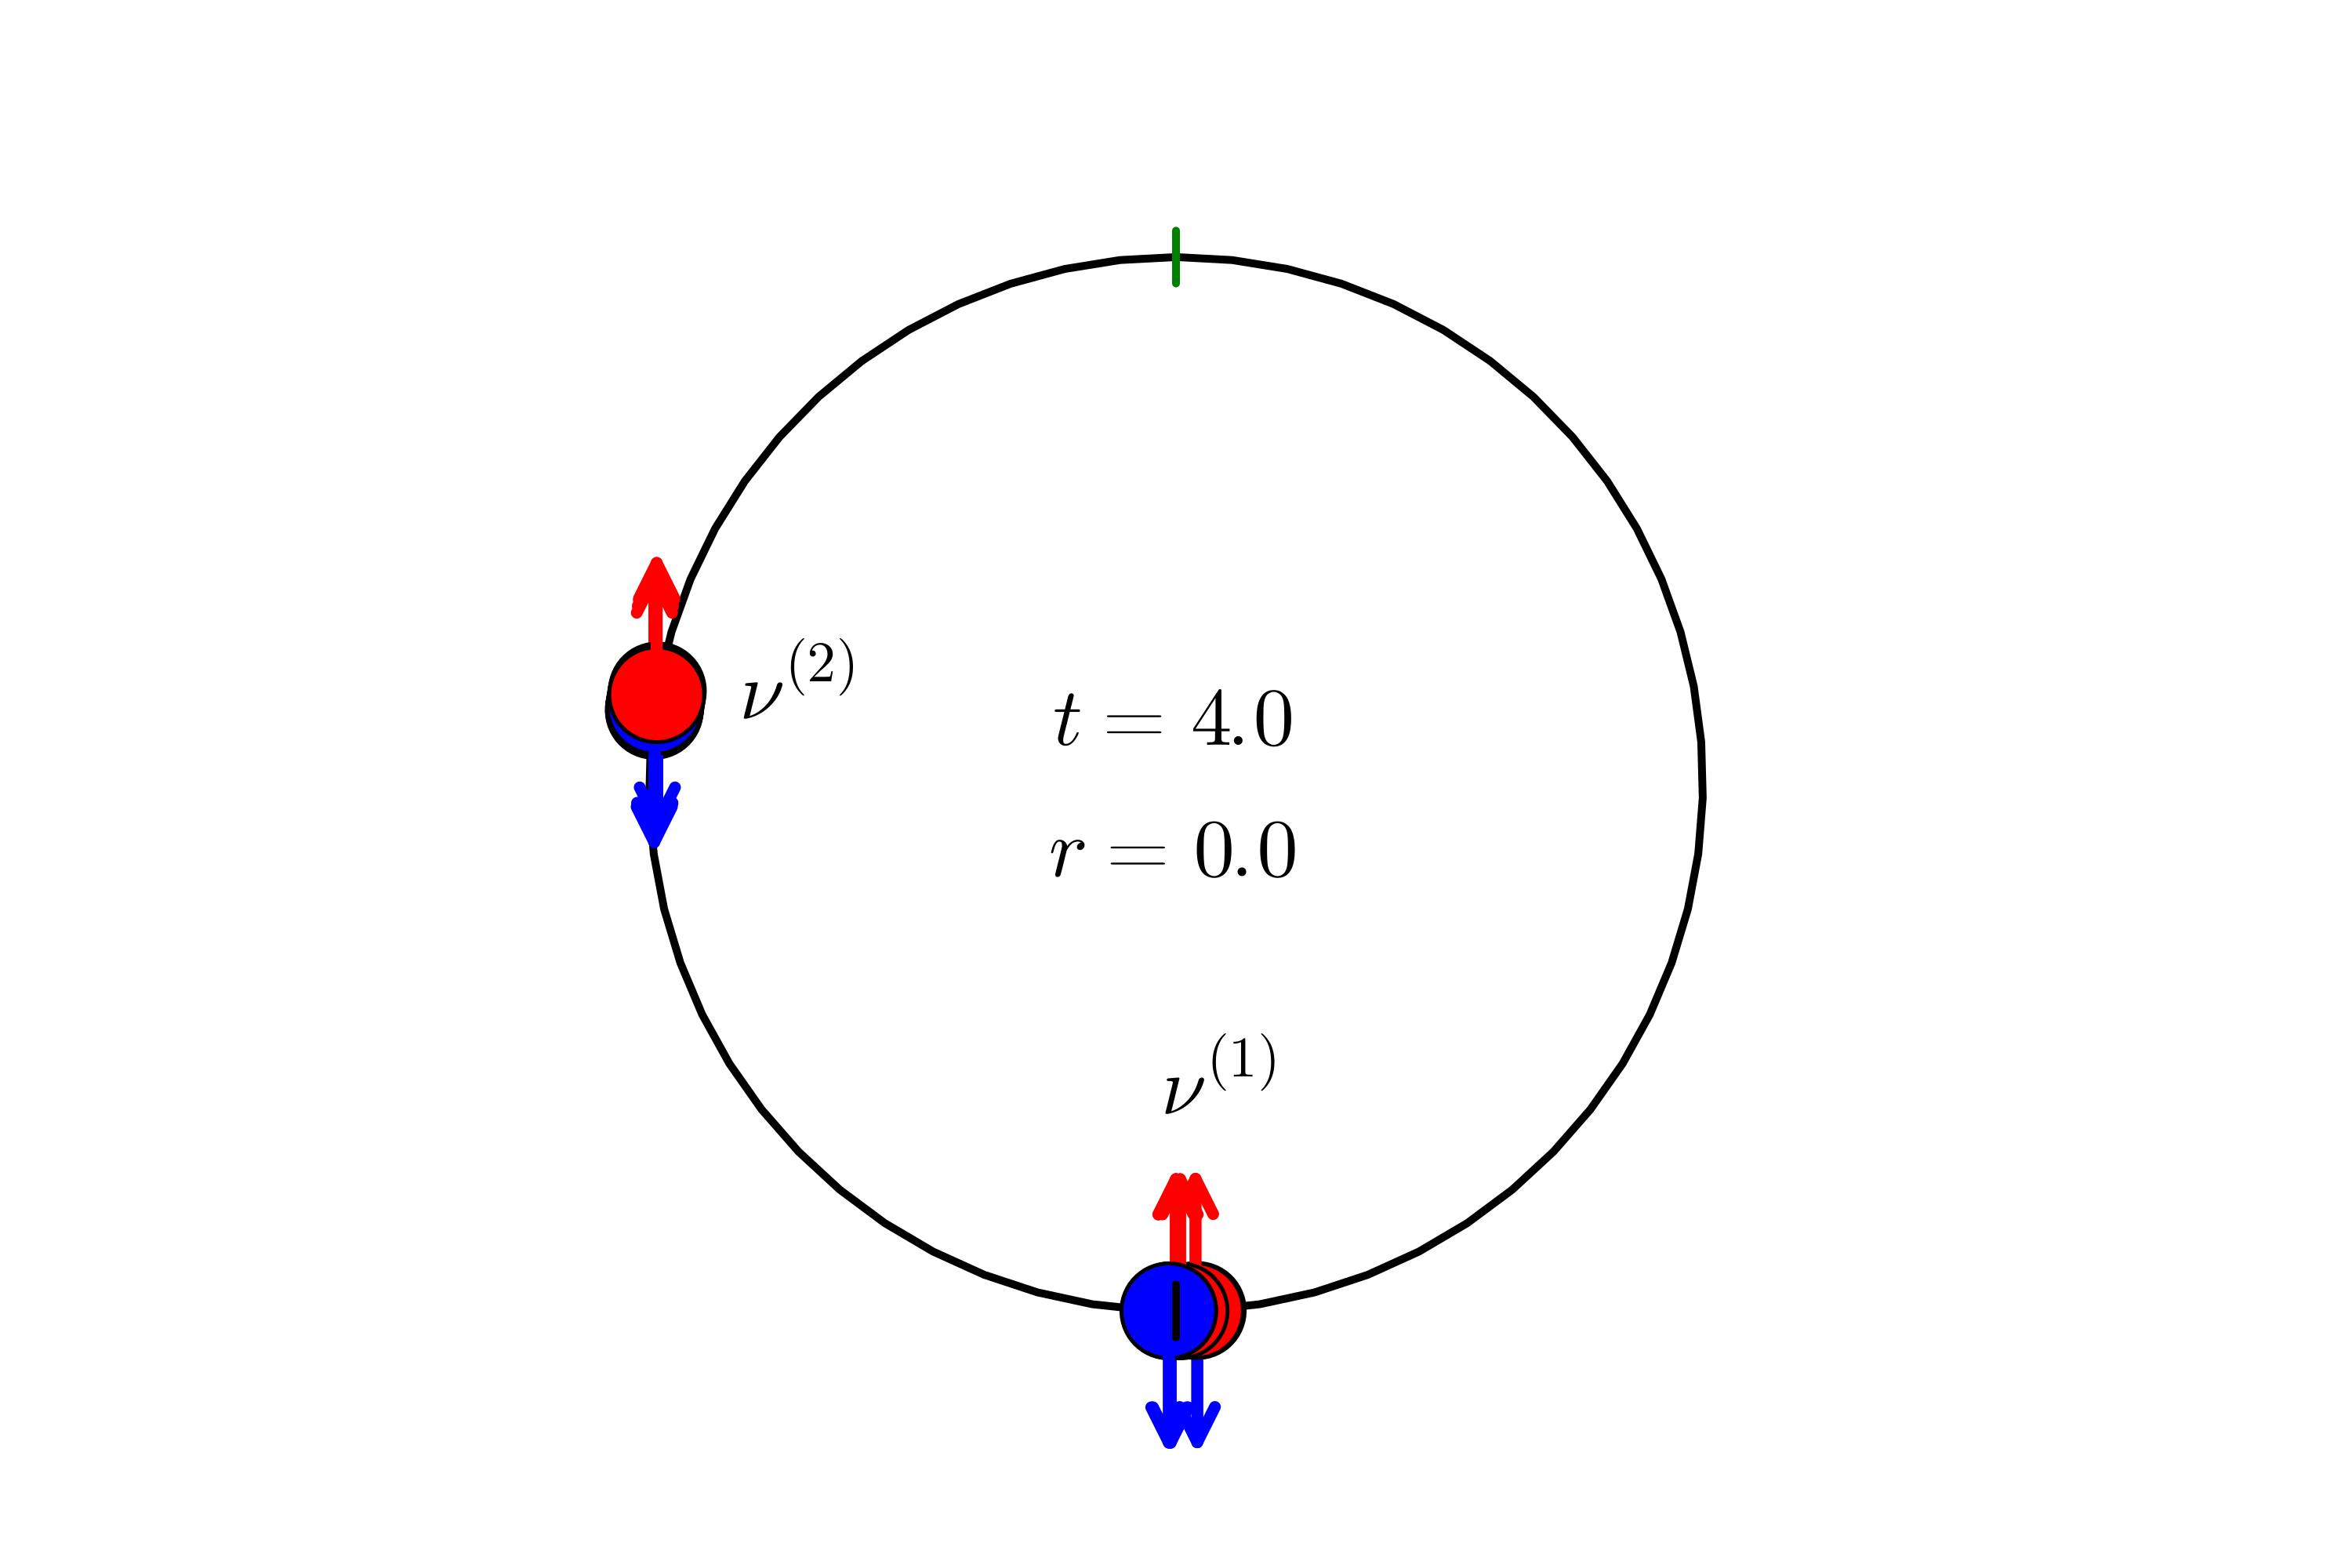

In [44]:
p1 = make_circle()
add_state(res[1][1], res[1][2])
RSGraphics.show_dash(0.0, 0.1)

# optional annotations can be added
t_label_x = 0.0
t_label_y = 0.125
t_label_str = "t = $(round(4.0, digits = 2))"
annotate!(t_label_x, t_label_y, latexstring(t_label_str))

r_label_x = 0.0
r_label_y = -0.125
r_label_str = "r = $(round(0.0, digits = 2))"
annotate!(r_label_x, r_label_y, latexstring(r_label_str))

V1_label_x = 0.1
V1_label_y = -0.55
V1_label_str = L"""\nu^{(1)}"""
annotate!(V1_label_x, V1_label_y, latexstring(V1_label_str))

V2_label_x = -0.7
V2_label_y = 0.2
V2_label_str = L"""\nu^{(2)}"""
annotate!(V2_label_x, V2_label_y, latexstring(V2_label_str))

RSGraphics.show_dash(1.0, 0.1, :green)

plot!(p1, dpi = 500)

In [45]:
savefig(p1, "Initial_State_Example_p1_meth.png")

"/Users/quaidzahid/Documents/Research Professor/Mikhail Erementchouk/HN_V2/scripts/Paper Figures/Initial_State_Example_p1_meth.png"

res_new = Any[(Int8[1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1], [-0.7999999999999998, -0.7871496529976412, 0.6532273965231017, 0.654663861749011, -0.8032660394529172, -0.7882035495120574, 0.6505920984202946, 0.6553632558907401, 0.646840175088327, 0.6434862401267765, -0.8034426755414001, -0.800023184571812, 0.6529025619541313, 0.6458009743078179, -0.7975328416966541, -0.8043205419769528])]


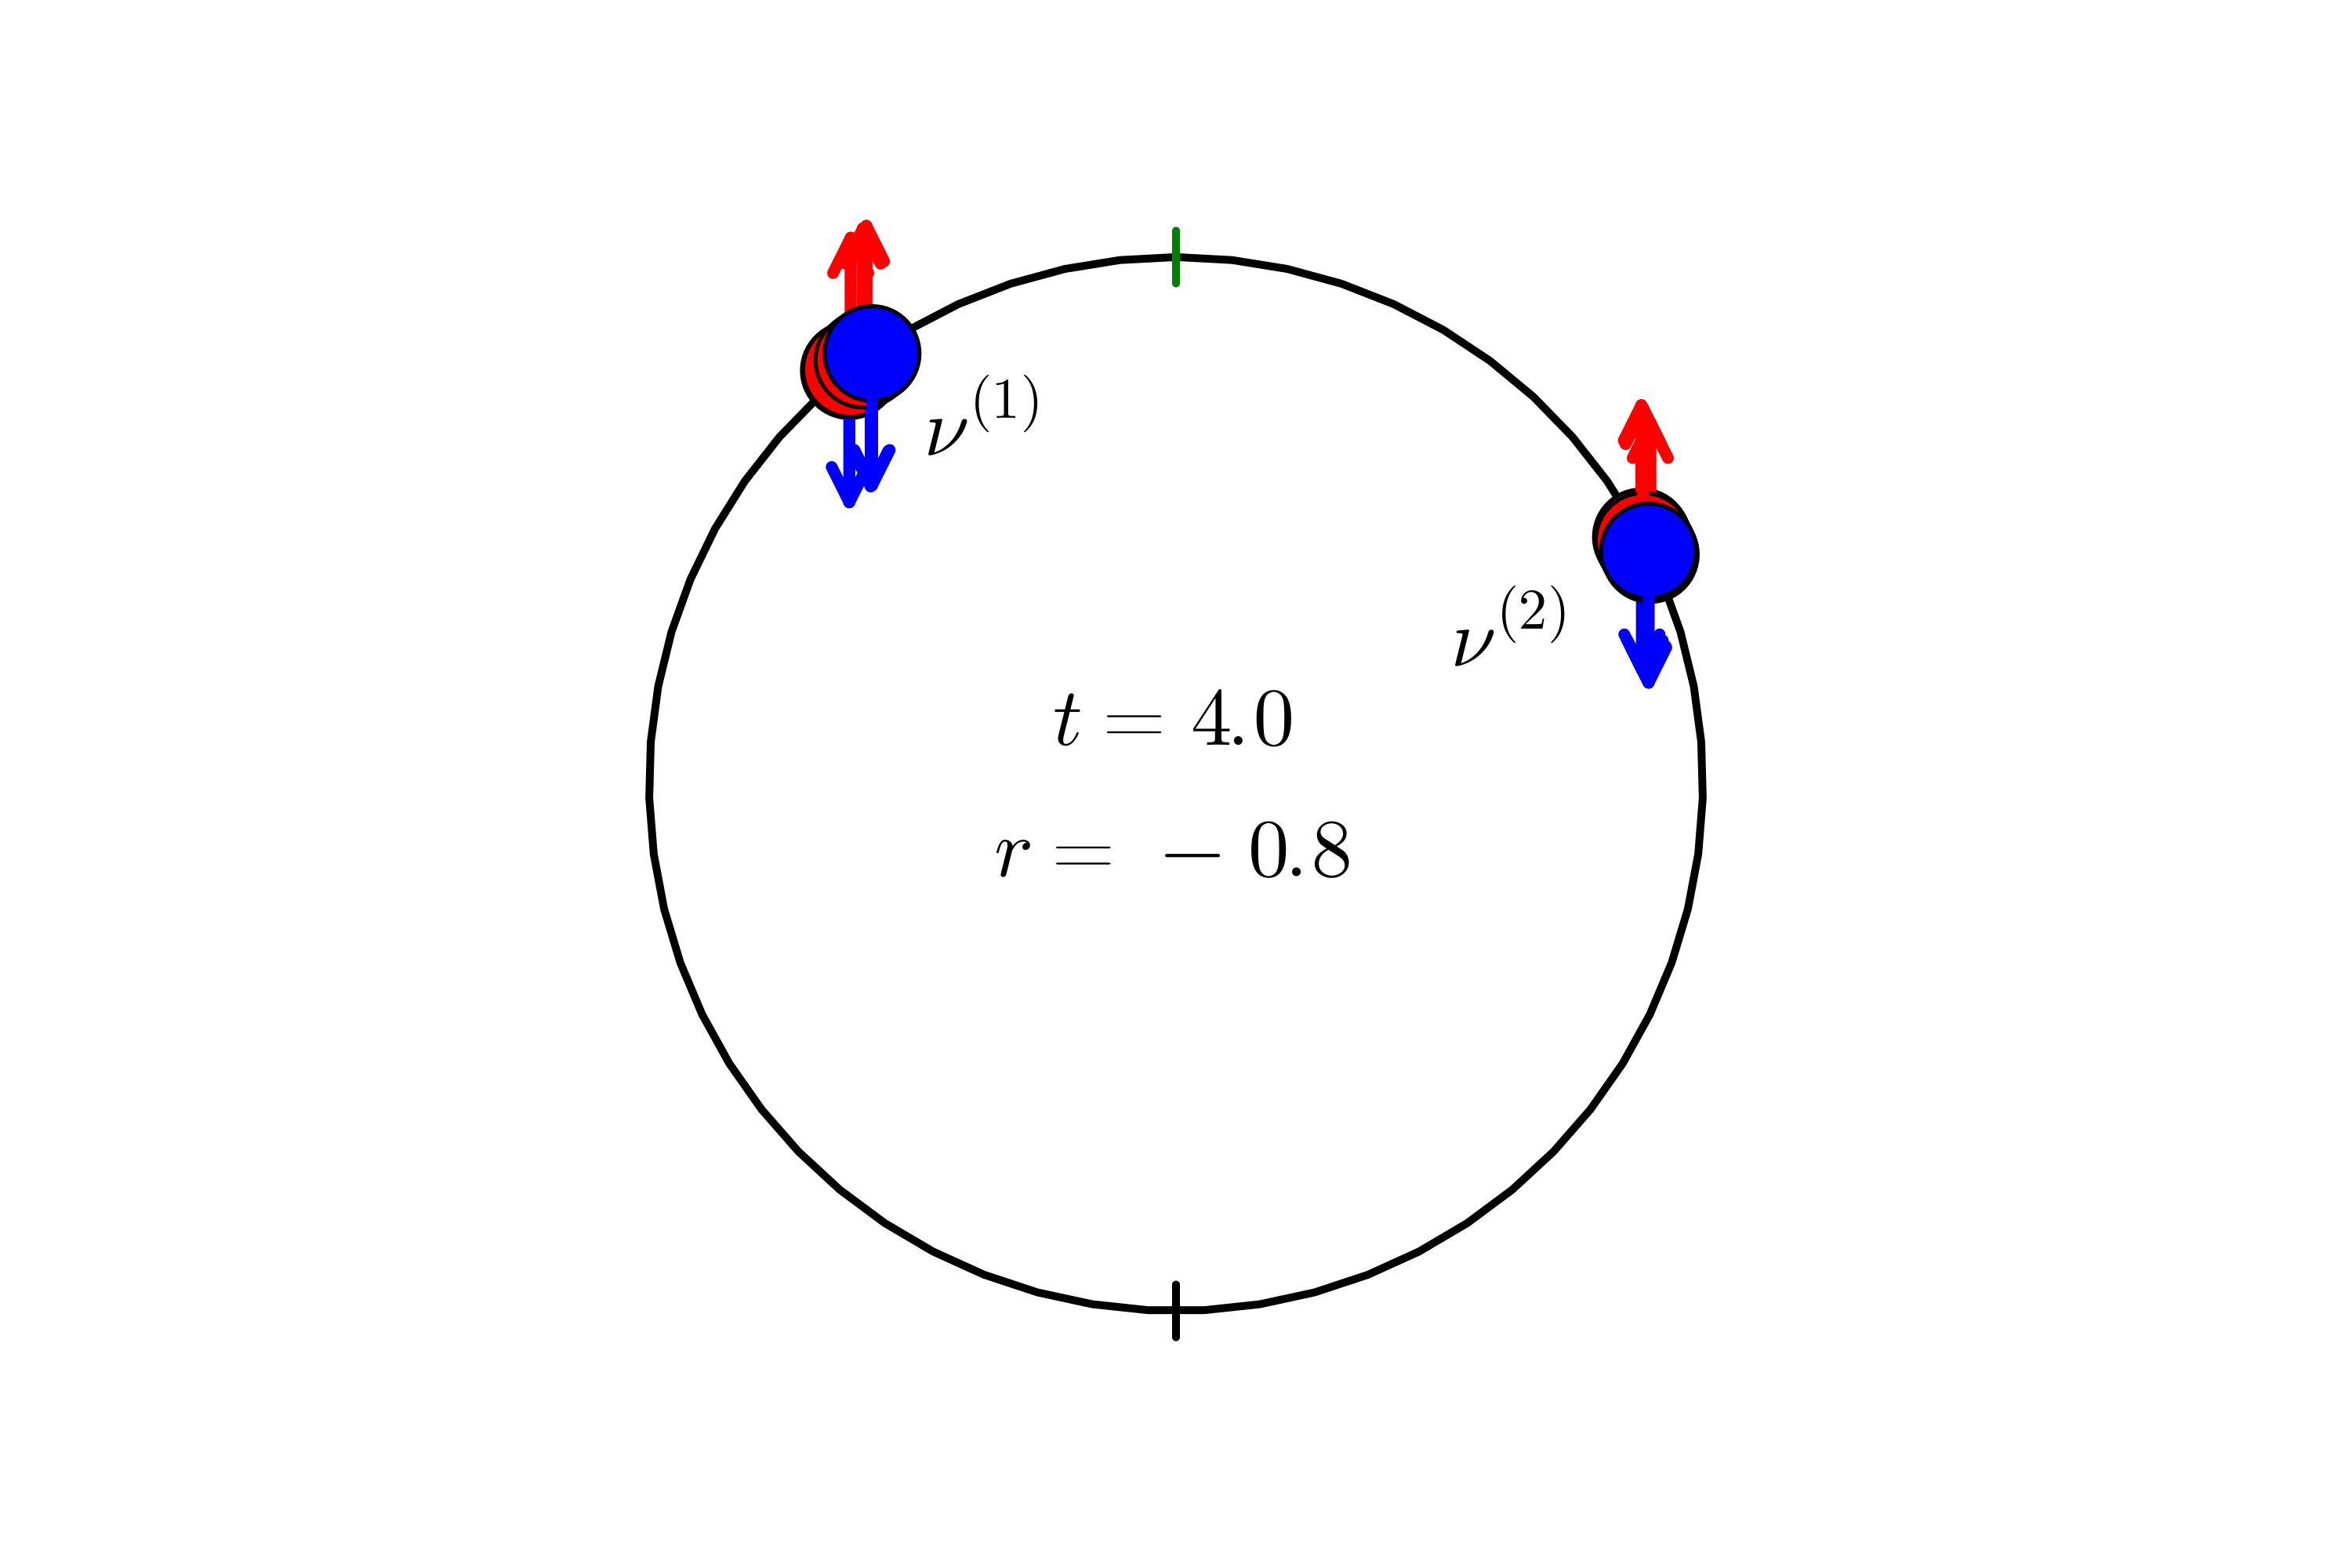

In [71]:
p2 = make_circle()
res_new = iterative_rotater_list(res[1], [3.8], 4)
@show res_new
add_state(res_new[1][1], res_new[1][2])
RSGraphics.show_dash(0.0, 0.1)

# optional annotations can be added
t_label_x = 0.0
t_label_y = 0.125
t_label_str = "t = $(round(4.0, digits = 2))"
annotate!(t_label_x, t_label_y, latexstring(t_label_str))

r_label_x = 0.0
r_label_y = -0.125
r_label_str = "r = $(round(-0.8, digits = 2))"
annotate!(r_label_x, r_label_y, latexstring(r_label_str))
RSGraphics.show_dash(1.0, 0.1, :green)

V1_label_x = -0.35
V1_label_y = 0.7
V1_label_str = L"""\nu^{(1)}"""
annotate!(V1_label_x, V1_label_y, latexstring(V1_label_str))

V2_label_x = 0.65
V2_label_y = 0.3
V2_label_str = L"""\nu^{(2)}"""
annotate!(V2_label_x, V2_label_y, latexstring(V2_label_str))


plot!(p2, dpi = 500)

In [72]:
savefig(p2, "Initial_State_Example_p2_meth.png")

"/Users/quaidzahid/Documents/Research Professor/Mikhail Erementchouk/HN_V2/scripts/Paper Figures/Initial_State_Example_p2_meth.png"

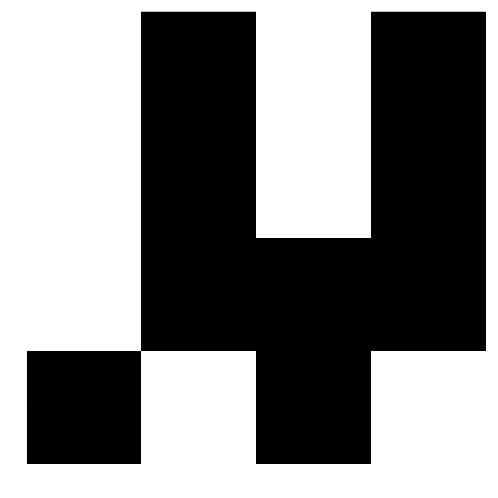

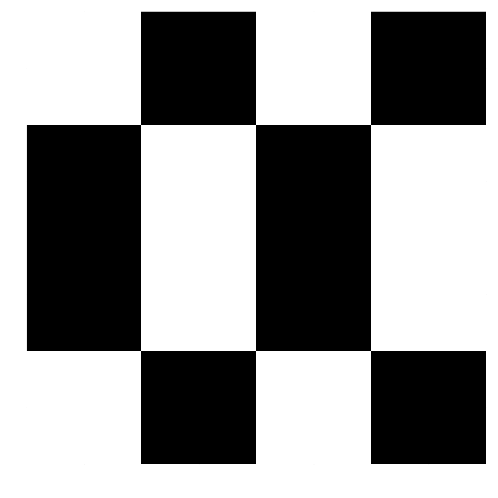

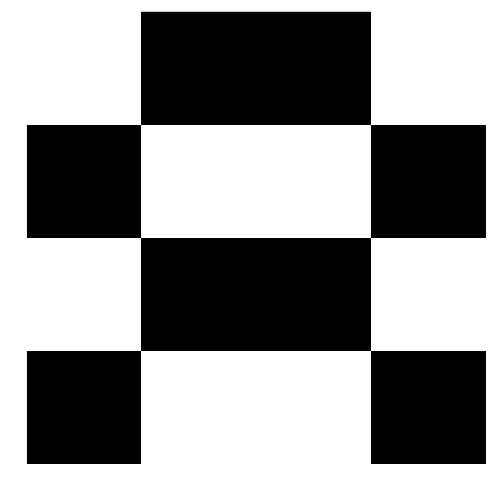

In [70]:
binary_image_visualizer(reshape(i_s[1],4,4), 500, "p0_image_meth", sav= true, d = true)
binary_image_visualizer(reshape(res[1][1],4,4), 500, "p1_image_meth", sav= true, d = true)
binary_image_visualizer(reshape(res_new[1][1],4,4), 500, "p2_image_meth", sav= true, d = true)